### load datasets and prepare jobs

In [34]:
import sys
sys.path.append("..")
from pathlib import Path
import numpy as np
from scipy import stats
import importlib
import src.assay_calibration.fit_utils.two_sample.fit
from src.assay_calibration.fit_utils.fit import Fit
importlib.reload(src.assay_calibration.fit_utils.two_sample.fit)
importlib.reload(src.assay_calibration.fit_utils.fit)
from src.assay_calibration.fit_utils.two_sample.fit import single_fit
from src.assay_calibration.fit_utils.two_sample import (density_utils,constraints, optimize)
import scipy.stats as sps
import matplotlib
matplotlib.set_loglevel("warning")
import numpy as np
from tqdm.auto import trange
import os
sys.path.append(str(Path(os.getcwd()).parent))
from src.assay_calibration.data_utils.dataset import (
    PillarProjectDataframe,
    Scoreset,
    BasicScoreset,
)
import json
import glob
import pickle
from joblib import Parallel, delayed

# Create output directory
output_dir = "/data/ross/assay_calibration/bootstrap_parallel"
os.makedirs(output_dir, exist_ok=True)

N_BOOTSTRAPS = 1000
NUM_FITS = 100  # fits per bootstrap
N_JOBS = 20 # number of parallel jobs to load datasets and execute fits


def load_and_generate_jobs(dataset_file, output_dir, N_BOOTSTRAPS, NUM_FITS):
    """Load a single dataset and generate all its jobs."""
    dataset_name = dataset_file.split('/')[-1][:-5]
    save_dir = f'{output_dir}/{dataset_name}'
    os.makedirs(save_dir, exist_ok=True)
    
    ds = Scoreset.from_json(dataset_file)
    fitter = Fit(ds)
    
    jobs = []
    job_metadata = {}
    
    for component_range in [[2], [3]]:
        for bootstrap_iter in range(N_BOOTSTRAPS):
            individual_jobs = fitter.generate_fit_jobs(
                component_range=component_range,
                bootstrap_seed=bootstrap_iter,
                check_monotonic=True,
                num_fits=NUM_FITS
            )
            
            for job in individual_jobs:
                job['dataset_name'] = dataset_name
                job['save_dir'] = save_dir
                jobs.append(job)
                
                key = (dataset_name, component_range[0], bootstrap_iter)
                if key not in job_metadata:
                    job_metadata[key] = []
                job_metadata[key].append(len(jobs) - 1)
    
    # print(f"Generated {len(jobs)} jobs for {dataset_name}",flush=True)
    return jobs, job_metadata

def prepare_all_jobs():
    """Load datasets in parallel, then pair 2c/3c jobs for simultaneous execution."""
    dataset_files = glob.glob("/data/ross/assay_calibration/scoresets/*.json")
    
    # Parallel dataset loading and job generation
    print(f"Loading {len(dataset_files)} datasets in parallel...")
    dataset_results = Parallel(n_jobs=N_JOBS, verbose=0)(
        delayed(load_and_generate_jobs)(
            dataset_file, output_dir, N_BOOTSTRAPS, NUM_FITS
        ) for dataset_file in dataset_files
    )
    
    # Combine all jobs but organize by dataset/bootstrap/fit for pairing
    job_pairs = {}  # Key: (dataset_name, bootstrap_seed, fit_idx), Value: {2: job, 3: job}
    
    for jobs, metadata in dataset_results:
        for job in jobs:
            key = (job['dataset_name'], job['bootstrap_seed'], job['fit_idx'])
            if key not in job_pairs:
                job_pairs[key] = {}
            job_pairs[key][job['num_components']] = job
    
    # Create paired list with 2c and 3c jobs side by side
    paired_jobs = []
    for key, components in job_pairs.items():
        assert 2 in components and 3 in components
        # Add 2c then 3c
        paired_jobs.append(components[2])
        paired_jobs.append(components[3])
    
    print(f"Total jobs: {len(paired_jobs)} (arranged in {len(paired_jobs)//2} pairs)")
    
    # Shuffle pairs while keeping 2c/3c together
    n_pairs = len(paired_jobs) // 2
    pair_indices = np.arange(n_pairs)
    np.random.shuffle(pair_indices)
    
    shuffled_jobs = []
    for idx in pair_indices:
        shuffled_jobs.append(paired_jobs[idx * 2])      # 2c job
        shuffled_jobs.append(paired_jobs[idx * 2 + 1])  # 3c job
    
    return shuffled_jobs

def execute_all_jobs(shuffled_jobs):
    # Execute all fits
    print("Starting parallel execution of fits...")
    Parallel(n_jobs=N_JOBS, batch_size='auto', verbose=0)(
        delayed(Fit.execute_fit_job)(job) for job in shuffled_jobs
    )
    
    print("All fits completed!")

shuffled_jobs = prepare_all_jobs()

Loading 83 datasets in parallel...
Total jobs: 49800 (arranged in 24900 pairs)


### execute jobs
#### this will take the longest

In [3]:
execute_all_jobs(shuffled_jobs)


Starting parallel execution of fits...
All fits completed!


### aggregate results

In [25]:
from collections import defaultdict

def aggregate_bootstrap_results(output_dir):
    """Aggregate individual fit results into bootstrap-level results."""
    
    for dataset_dir in glob.glob(f"{output_dir}/*/"):
        dataset_name = os.path.basename(dataset_dir.rstrip('/'))
        
        # Find all individual fit files
        fit_files = glob.glob(f"{dataset_dir}/{dataset_name}_b*_c*_f*.pkl")
        
        # Group by bootstrap
        bootstrap_groups = defaultdict(list)
        for fit_file in fit_files:
            # Parse filename
            base = os.path.basename(fit_file).replace('.pkl', '')
            parts = base.split('_')
            bootstrap_seed = int(parts[-3][1:])  # Remove 'b' prefix
            num_components = int(parts[-2][1:])  # Remove 'c' prefix
            fit_idx = int(parts[-1][1:])  # Remove 'f' prefix
            
            bootstrap_groups[(bootstrap_seed, num_components)].append((fit_file, fit_idx))
        
        # Process each bootstrap
        for (bootstrap_seed, num_components), fits in bootstrap_groups.items():
            fit_files, fit_indices = zip(*fits)  # unzip list of tuples
            fit_files = list(fit_files)
            fit_indices = list(fit_indices)
            output_file = f"{dataset_dir}/aggregated_{num_components}c_con_{bootstrap_seed}.pkl"
            
            # Skip if already aggregated
            # if os.path.exists(output_file):
            #     continue
                
            # Load all fits for this bootstrap
            fits_data = {}
            for fit_file, fit_idx in zip(fit_files, fit_indices):
                try:
                    with open(fit_file, 'rb') as f:
                        fits_data[fit_idx] = pickle.load(f)
                        '''
                        can remove file here if need to free up space. will be ~1.0T
                        '''
                except EOFError:
                    continue
            
            if not fits_data:
                continue
                
            # Find best fit
            val_lls = {fit_idx: f['val_ll'] if f['val_ll'] is not None else -np.inf for fit_idx,f in fits_data.items()}
            best_idx = max(val_lls, key=val_lls.get)
            
            # Create aggregated result
            save_dict = {
                'best_fit': fits_data[best_idx]['fit'],
                'best_val_ll': val_lls[best_idx],
                # 'all_val_lls': val_lls,
                'n_fits': len(fits_data)
            }
            save_dict['best_fit'].pop('history', None) # free up space
            
            with open(output_file, 'wb') as f:
                pickle.dump(save_dict, f)
            
            # print(f"Aggregated: {dataset_name} {num_components}c bootstrap {bootstrap_seed}")

aggregate_bootstrap_results(output_dir)

Aggregated: ASPA_Grønbæk-Thygesen_2024_abundance 3c bootstrap 1
Aggregated: ASPA_Grønbæk-Thygesen_2024_abundance 2c bootstrap 2
Aggregated: ASPA_Grønbæk-Thygesen_2024_abundance 2c bootstrap 0
Aggregated: ASPA_Grønbæk-Thygesen_2024_abundance 2c bootstrap 1
Aggregated: ASPA_Grønbæk-Thygesen_2024_abundance 3c bootstrap 2
Aggregated: ASPA_Grønbæk-Thygesen_2024_abundance 3c bootstrap 0
Aggregated: ASPA_Grønbæk-Thygesen_2024_toxicity 2c bootstrap 0
Aggregated: ASPA_Grønbæk-Thygesen_2024_toxicity 2c bootstrap 1
Aggregated: ASPA_Grønbæk-Thygesen_2024_toxicity 3c bootstrap 2
Aggregated: ASPA_Grønbæk-Thygesen_2024_toxicity 3c bootstrap 0
Aggregated: ASPA_Grønbæk-Thygesen_2024_toxicity 2c bootstrap 2
Aggregated: ASPA_Grønbæk-Thygesen_2024_toxicity 3c bootstrap 1
Aggregated: BAP1_Waters_2024 3c bootstrap 1
Aggregated: BAP1_Waters_2024 2c bootstrap 0
Aggregated: BAP1_Waters_2024 3c bootstrap 0
Aggregated: BAP1_Waters_2024 2c bootstrap 2
Aggregated: BAP1_Waters_2024 3c bootstrap 2
Aggregated: BAP1_W

### save all results into one file

In [28]:
all_datasets_results = defaultdict(dict)
for dataset_dir in glob.glob(f"{output_dir}/*/"):
    dataset_name = os.path.basename(dataset_dir.rstrip('/'))
    
    for aggregated_3c_f in glob.glob(f'{dataset_dir}/aggregated_3c_con_*.pkl'):
        aggregated_2c_f = aggregated_3c_f.replace('aggregated_3c_con','aggregated_2c_con')

        bootstrap_idx = int(os.path.basename(aggregated_3c_f).replace('.pkl', '').split('_')[-1]) # get bootstrap idx
    
        with open(aggregated_3c_f,'rb') as f:
            fit_3c = pickle.load(f)
        with open(aggregated_2c_f,'rb') as f:
            fit_2c = pickle.load(f)
    
        all_datasets_results[dataset_name][bootstrap_idx] = {'2c': 
                                                                 {'best_fit': fit_2c['best_fit'],
                                                                  'best_val_ll': fit_2c['best_val_ll']},
                                                             '3c':
                                                                 {'best_fit': fit_3c['best_fit'],
                                                                  'best_val_ll': fit_3c['best_val_ll']},
                                                            }

with open(f'{output_dir}/all_dataset_results_{N_BOOTSTRAPS}bootstraps_{NUM_FITS}fits.pkl','wb') as f:
    pickle.dump(all_datasets_results, f)

In [35]:
all_datasets_results

defaultdict(dict,
            {'ASPA_Grønbæk-Thygesen_2024_abundance': {1: {'2c': {'best_fit': {'component_params': [(-0.038383368007996015,
                   0.026993583083081987,
                   0.05157644683360218),
                  (-0.16879165014222552,
                   0.8388455635386485,
                   0.2151729841329211)],
                 'weights': array([[0.75547601, 0.24452399],
                        [0.        , 1.        ],
                        [0.31024167, 0.68975833]]),
                 'likelihoods': array([-0.23996027, -0.2120606 , -0.18463975, -0.16021507, -0.13539771,
                        -0.10490793, -0.06425465, -0.01076526,  0.0263653 ,  0.02930307,
                         0.02990957,  0.03003421,  0.03009971,  0.03016524,  0.03021436,
                         0.03024947,  0.03027151,  0.03028698,  0.0302959 ,  0.03030149,
                         0.03030671,  0.03031183,  0.03031685,  0.03031872,  0.03032343,
                         0.030328

### post-hoc bootstrap 2c vs. 3c analysis w/ plot

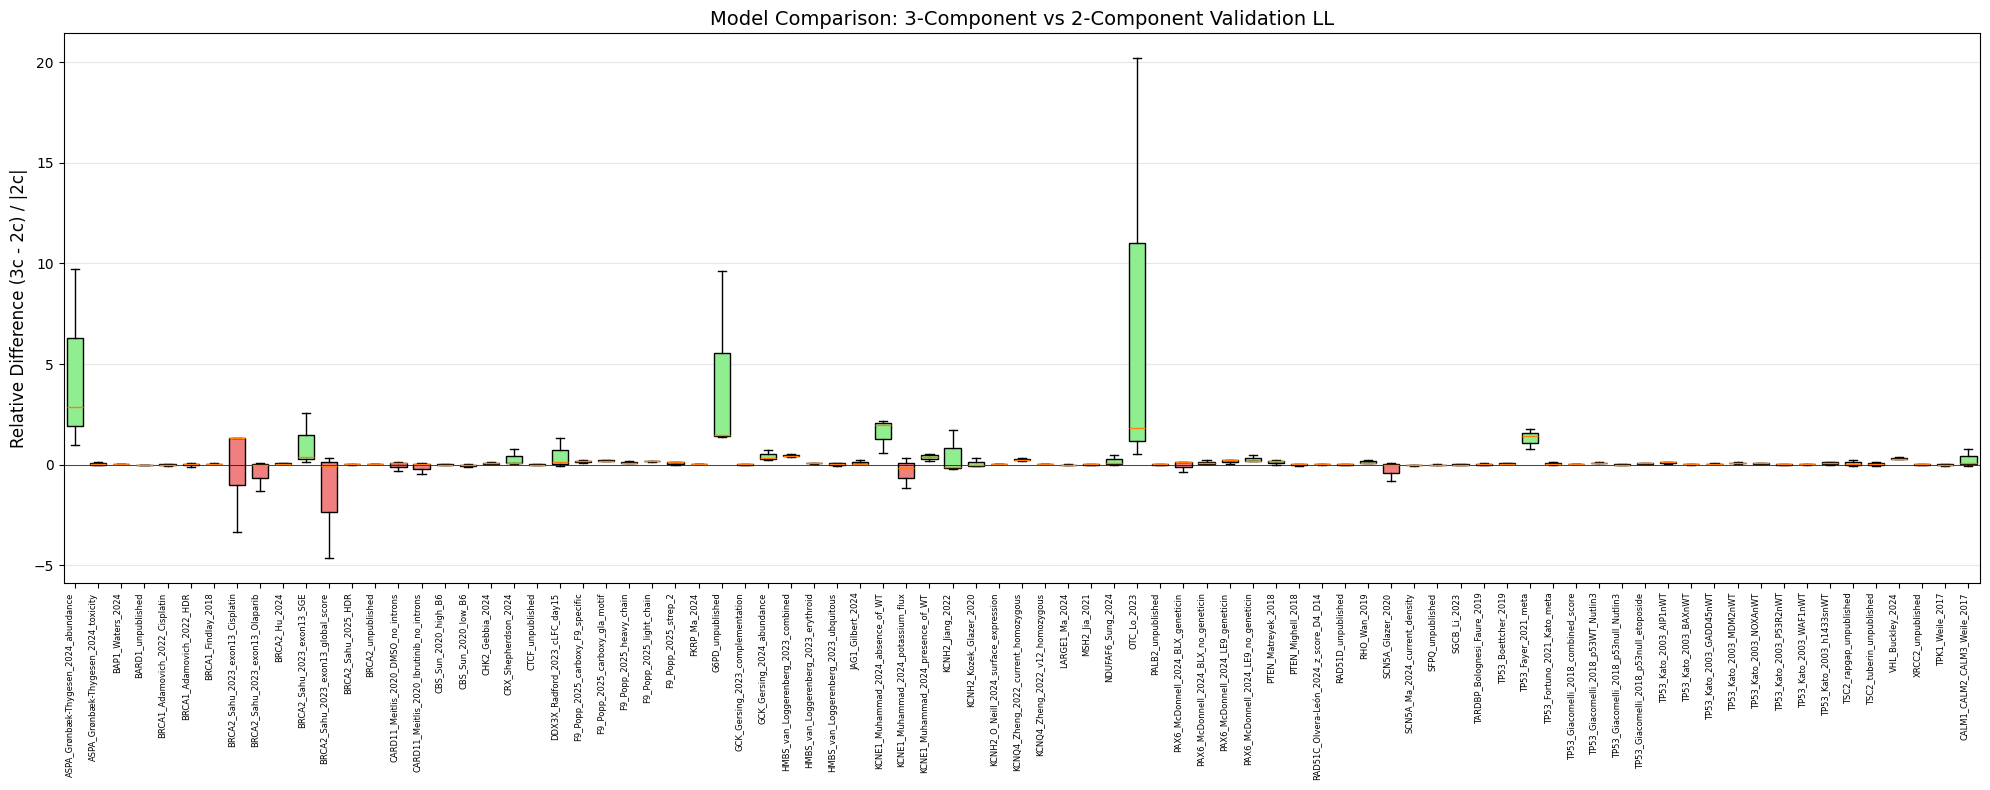

In [32]:
import matplotlib.pyplot as plt

dataset_names = []
all_relative_diffs = []

for dataset_name in all_datasets_results:
    relative_diffs = []
    for bootstrap_idx, indv_bootstrap_results in all_datasets_results[dataset_name].items():
        val_ll_2c = indv_bootstrap_results['2c']['best_val_ll']
        val_ll_3c = indv_bootstrap_results['3c']['best_val_ll']
        
        # Handle potential division issues
        if val_ll_2c != 0:
            relative_diff = (val_ll_3c - val_ll_2c) / abs(val_ll_2c)
            relative_diffs.append(relative_diff)
    
    if relative_diffs:
        dataset_names.append(dataset_name)
        all_relative_diffs.append(relative_diffs)

fig, ax = plt.subplots(figsize=(20, 8))

bp = ax.boxplot(all_relative_diffs, positions=range(len(dataset_names)),
                patch_artist=True, widths=0.7)

for idx, (patch, diffs) in enumerate(zip(bp['boxes'], all_relative_diffs)):
    if np.mean(diffs) > 0:
        patch.set_facecolor('lightgreen')
    else:
        patch.set_facecolor('lightcoral')

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xticks(range(len(dataset_names)))
ax.set_xticklabels(dataset_names, rotation=90, ha='right', fontsize=6)
ax.set_ylabel('Relative Difference (3c - 2c) / |2c|', fontsize=12)
ax.set_title('Model Comparison: 3-Component vs 2-Component Validation LL', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('relative_diff_all_datasets_single.png', dpi=200, bbox_inches='tight')
plt.show()
